In [1]:
import os
import sys
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Subset, random_split
from torch.optim.lr_scheduler import StepLR 
from torchinfo import summary
from tqdm.notebook import tqdm

import mlflow
import mlflow.pytorch

In [2]:
# force project root into sys.path
project_root = os.path.abspath("..")
print("Using project root:", project_root)

if project_root not in sys.path:
    sys.path.insert(0, project_root)

Using project root: c:\Users\DELL\Desktop\endtoend-mlops\projects\covid_chest_classifier


In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
print(f"Using {device} device")

Using cpu device


In [4]:
data_dir = "C://Users//DELL//Desktop//endtoend-mlops//data//raw//Covid19-dataset//"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Will read traindata from", train_dir)
print("And the test data from", test_dir)

Will read traindata from C://Users//DELL//Desktop//endtoend-mlops//data//raw//Covid19-dataset//train
And the test data from C://Users//DELL//Desktop//endtoend-mlops//data//raw//Covid19-dataset//test


In [5]:
classes = os.listdir(train_dir)

print("List of classes:", classes)

List of classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [6]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [7]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches +=1
    mean = channels_sum/num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    
    return mean, std

In [8]:
transform_normalized = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.485, 0.456, 0.406),
            std = (0.229, 0.224, 0.225)
            )
   ]
    )

print(type(transform_normalized))
print("-------------")
print(transform_normalized)

<class 'torchvision.transforms.transforms.Compose'>
-------------
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


In [9]:
normalized_dataset = datasets.ImageFolder(root=train_dir, transform=transform_normalized)

print('Length of dataset:', len(normalized_dataset))

Length of dataset: 251


In [10]:
g = torch.Generator()
g.manual_seed(42)

In [11]:
train_dataset, val_dataset = random_split(normalized_dataset, [0.8, 0.2], generator=g)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_normalized)

print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))
print("Length of test dataset:", len(test_dataset))

Length of training dataset: 201
Length of validation dataset: 50
Length of test dataset: 66


In [12]:
percent_train = np.round(100*len(train_dataset)/ len(normalized_dataset),2)
percent_val = np.round(100*len(val_dataset) / len(normalized_dataset), 2)


print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val} of full data")

Train data is 80.08% of full data
Validation data is 19.92 of full data


In [13]:
def class_counts(dataset):
    ds = dataset.dataset if isinstance(dataset, Subset) else dataset
    counts = Counter(lbl for _, lbl in tqdm(dataset, desc="Counting classes"))
    return pd.Series({cls: counts[idx] for cls, idx in ds.class_to_idx.items()})

In [14]:
train_class_distributions = class_counts(train_dataset)
train_class_distributions

Counting classes:   0%|          | 0/201 [00:00<?, ?it/s]

Covid              94
Normal             56
Viral Pneumonia    51
dtype: int64

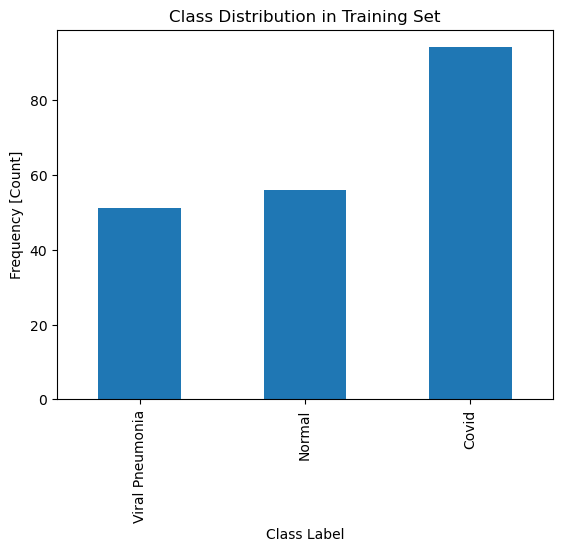

In [15]:
train_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Training Set");

Counting classes:   0%|          | 0/50 [00:00<?, ?it/s]

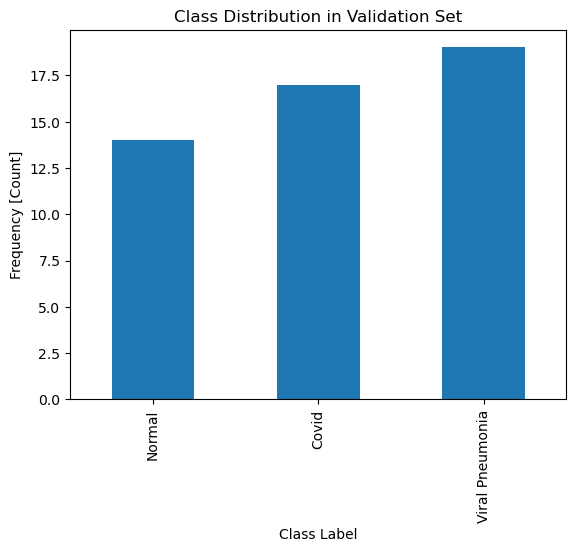

In [16]:
validation_class_distributions = class_counts(val_dataset)

validation_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Validation Set");

Counting classes:   0%|          | 0/66 [00:00<?, ?it/s]

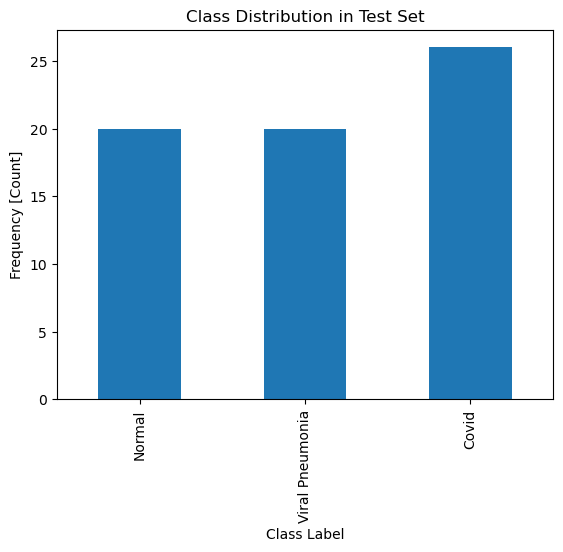

In [17]:
test_class_distributions = class_counts(test_dataset)

test_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Test Set");

In [18]:
# --- Hyperparameters ---
batch_size = 32
epochs_to_train = 23
initial_learning_rate = 1e-3
weight_decay = 1e-4
step_size = 4      # decay every 4 epochs
gamma = 0.2        # reduce LR by 0.2
loss_fn = nn.CrossEntropyLoss()
height=224
width=224

In [19]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

print(type(train_loader))  
print(type(val_loader))    
print(type(test_loader))   

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [20]:
# Load ResNet-18 with pretrained weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)

in_features = model.fc.in_features

# 3. Replace the FC layer with a new one for 3 classes
model.fc = nn.Linear(in_features, 3)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
for params in model.parameters():
    params.requires_grad = False
    
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

## Checking the Size of I/O features

In [23]:
in_feat = model.fc.in_features
print(in_feat)

512


In [24]:
out_feat = model.fc.out_features
print(out_feat)

3


In [25]:
modified_last_layer = nn.Sequential(
    nn.Linear(in_feat, 253),  
    nn.ReLU(),
    nn.Linear(253, out_feat)
)

model.fc = modified_last_layer
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate, weight_decay=weight_decay)

print(loss_fn)
print("-------------------")
print(optimizer)

CrossEntropyLoss()
-------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


In [27]:
model.to(device)
print(next(model.parameters()).device)

cpu


In [28]:
# Initialize the learning rate scheduler
scheduler = StepLR(
    optimizer,
    step_size = step_size,
    gamma = gamma,
)

print(type(scheduler))

<class 'torch.optim.lr_scheduler.StepLR'>


In [29]:
summary(model, input_size = (batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 3]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]  

In [30]:
def early_stopping(validation_loss, best_val_loss, counter):
    
    stop = False
    if validation_loss < best_val_loss:
        counter = 0
    else:
        counter += 1
    
    # check if counter is >= patience (5 epoch in our case)
    # set stop variable accordingly
    if counter >= 5:
        stop = True
        
    return counter, stop

In [31]:
def checkpointing(validation_loss, best_val_loss, model, opitimizer, save_path):
    
    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict":model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )
        print(f"Checkpoint saved with validation{validation_loss:.4f}")

In [33]:
from src.training import train_epoch,train,score

In [34]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=23,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,  
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []
    
    # Track best model for checkpointing/early stopping
    best_val_loss = float("inf")
    early_stopping_counter = 0
    stop = False
    
    print("Model evaluation before start of training...")

    # Initial evaluation
    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)   
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = score(model, val_loader, loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")
        
        # Train one epoch
        train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluate validation results
        val_loss, val_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Logging
        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.2f}%")
        print(f"Validation loss: {val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        
        # Log learning rate
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()
            
        # Checkpointing
        if checkpoint_path:
            checkpointing(val_loss, best_val_loss, model, optimizer, checkpoint_path)
            
        # Early Stopping
        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                val_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break
        
        # Update best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
                
    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )


In [35]:
# --- MLflow step: start experiment and log hyperparameters ---
from src.ml_flow import init_experiment, log_params

if mlflow.active_run() is not None:
    mlflow.end_run()

run = init_experiment("covid_chest_classification")
hyperparams = {
    "batch_size": batch_size,
    "epochs": epochs_to_train,
    "optimizer": optimizer,
    "learning_rate": 1e-3,
    "weight_decay": weight_decay,
    "scheduler_step_size": step_size,
    "scheduler_gamma": gamma
}
log_params(hyperparams)

In [36]:
# Call training function and store results
train_results = train(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="C://Users//DELL//Desktop//endtoend-mlops//projects//covid_chest_classifier//model//LR_model.pth",
    early_stopping=early_stopping,  
)

# Unpack results
learning_rates, train_losses, val_losses, train_accuracies, val_accuracies, last_epoch = train_results

print(f"Training finished at epoch {last_epoch}")
print(f"Final validation accuracy: {val_accuracies[-1]*100:.2f}%")

Model evaluation before start of training...


Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]



Starting epoch 1/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.9062
Training accuracy: 61.61%
Validation loss: 0.7959
Validation accuracy: 56.25%
Checkpoint saved with validation0.7959


Starting epoch 2/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.5370
Training accuracy: 70.54%
Validation loss: 0.4914
Validation accuracy: 59.38%
Checkpoint saved with validation0.4914


Starting epoch 3/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.5535
Training accuracy: 60.27%
Validation loss: 0.5517
Validation accuracy: 50.00%


Starting epoch 4/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.3001
Training accuracy: 83.04%
Validation loss: 0.3059
Validation accuracy: 71.88%
Checkpoint saved with validation0.3059


Starting epoch 5/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.2914
Training accuracy: 82.14%
Validation loss: 0.3086
Validation accuracy: 67.19%


Starting epoch 6/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6
Training loss: 0.3874
Training accuracy: 73.66%
Validation loss: 0.4176
Validation accuracy: 53.12%


Starting epoch 7/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7
Training loss: 0.3793
Training accuracy: 75.00%
Validation loss: 0.4159
Validation accuracy: 53.12%


Starting epoch 8/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8
Training loss: 0.2680
Training accuracy: 78.12%
Validation loss: 0.3003
Validation accuracy: 60.94%
Checkpoint saved with validation0.3003


Starting epoch 9/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9
Training loss: 0.2019
Training accuracy: 83.04%
Validation loss: 0.2291
Validation accuracy: 68.75%
Checkpoint saved with validation0.2291


Starting epoch 10/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10
Training loss: 0.1755
Training accuracy: 84.82%
Validation loss: 0.2020
Validation accuracy: 67.19%
Checkpoint saved with validation0.2020


Starting epoch 11/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 11
Training loss: 0.1541
Training accuracy: 86.16%
Validation loss: 0.1836
Validation accuracy: 70.31%
Checkpoint saved with validation0.1836


Starting epoch 12/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 12
Training loss: 0.1480
Training accuracy: 86.61%
Validation loss: 0.1757
Validation accuracy: 73.44%
Checkpoint saved with validation0.1757


Starting epoch 13/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 13
Training loss: 0.1487
Training accuracy: 86.61%
Validation loss: 0.1775
Validation accuracy: 71.88%


Starting epoch 14/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 14
Training loss: 0.1485
Training accuracy: 86.61%
Validation loss: 0.1777
Validation accuracy: 71.88%


Starting epoch 15/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 15
Training loss: 0.1485
Training accuracy: 86.61%
Validation loss: 0.1759
Validation accuracy: 71.88%


Starting epoch 16/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 16
Training loss: 0.1479
Training accuracy: 87.05%
Validation loss: 0.1790
Validation accuracy: 70.31%


Starting epoch 17/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 17
Training loss: 0.1490
Training accuracy: 86.61%
Validation loss: 0.1840
Validation accuracy: 70.31%
Early stopping triggered after 17 epochs
Training finished at epoch 17
Final validation accuracy: 70.31%


In [37]:
torch.save(model.state_dict(), "C://Users//DELL//Desktop//endtoend-mlops//projects//covid_chest_classifier//model//best_model.pth")

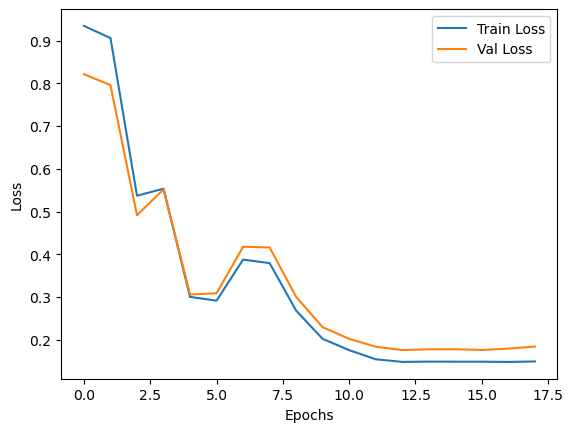

In [38]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

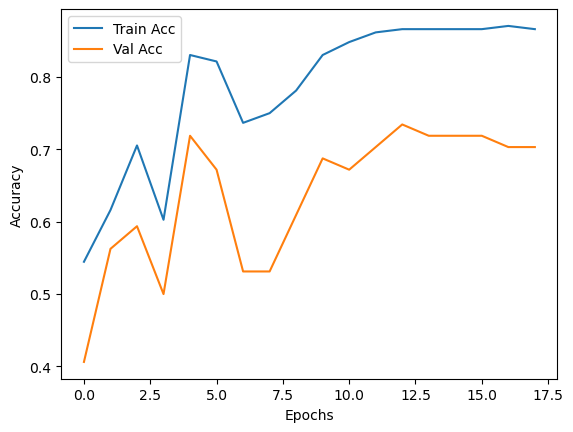

In [39]:
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [40]:
state_dict = torch.load("C://Users//DELL//Desktop//endtoend-mlops//projects//covid_chest_classifier//model//best_model.pth", weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [41]:
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=classes))
print(confusion_matrix(all_labels, all_preds))

                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      0.60      0.75        20
Viral Pneumonia       0.71      1.00      0.83        20

       accuracy                           0.88        66
      macro avg       0.90      0.87      0.86        66
   weighted avg       0.91      0.88      0.87        66

[[26  0  0]
 [ 0 12  8]
 [ 0  0 20]]


In [45]:
import src.grad_cam
from src.grad_cam import generate_gradcam, GradCAM
from importlib import reload

# reload 
reload(src.grad_cam)

<module 'src.grad_cam' from 'c:\\Users\\DELL\\Desktop\\endtoend-mlops\\projects\\covid_chest_classifier\\src\\grad_cam.py'>

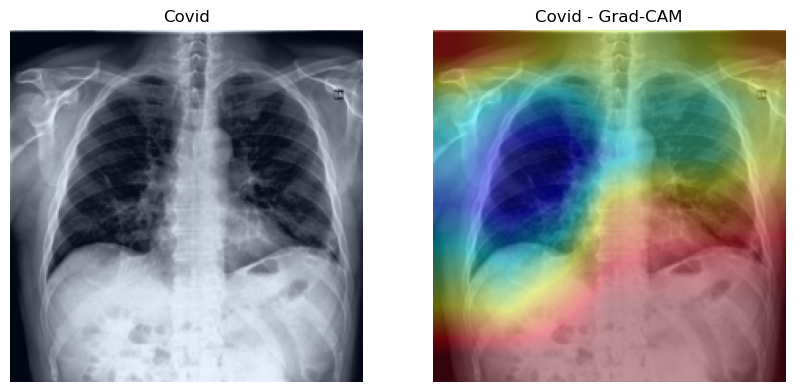

[INFO] Saved Grad-CAM comparison to gradcam_outputs\0_Covid.png


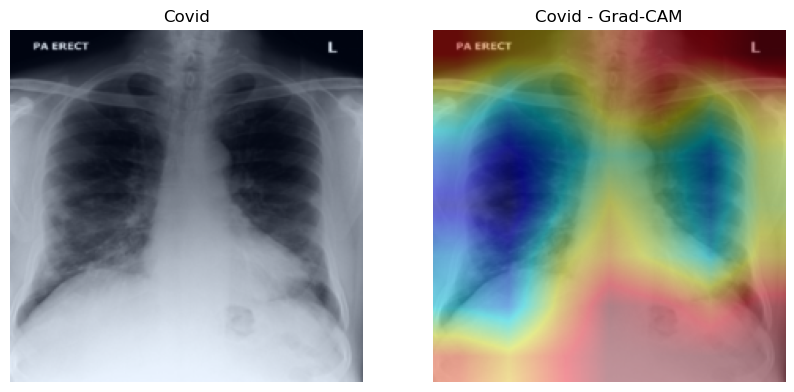

[INFO] Saved Grad-CAM comparison to gradcam_outputs\1_Covid.png


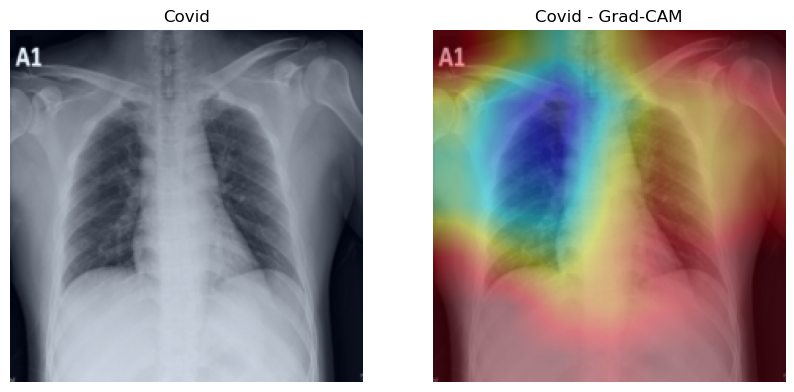

[INFO] Saved Grad-CAM comparison to gradcam_outputs\2_Covid.png


In [46]:
# Generate Grad-CAM for first 5 images
generate_gradcam(model, test_loader, classes, save_dir="gradcam_outputs", num_images=3, device=device)